# MetaCyc Pathway Abundance Analysis


## Setup

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
from pathlib import Path

%matplotlib inline

In [2]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [3]:
import sys
sys.path.append(root.as_posix())

import utils

In [4]:
metagenome = "pathway_abundance"
core_metrics_res = data_dir / f"{metagenome}_core_metrics"
picrust_res = data_dir / "q2-picrust2_fullpipeline"

output_dir = data_dir / f"{metagenome}_downstream_analysis"
output_dir.mkdir(exist_ok=True)

vis_dir = vis_dir / f"{metagenome}_downstream_analysis"
vis_dir.mkdir(exist_ok=True)

## Beta diversity

In [5]:
! ls $core_metrics_res

bray_curtis_distance_matrix.qza  jaccard_pcoa_results.qza
bray_curtis_emperor.qzv		 observed_features_vector.qza
bray_curtis_pcoa_results.qza	 rarefied_table.qza
evenness_vector.qza		 scatter-plot-recov-day.qzv
jaccard_distance_matrix.qza	 shannon_vector.qza
jaccard_emperor.qzv		 spearman-recov-day.qza


### Visulization of PCA plot


In [6]:
meta = pd.read_csv(data_dir / "metadata.tsv", sep="\t", index_col=0)
meta.head()

,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
sample-id,,,,,,
EG2580,P042,liquid,F,13,17.0,2
EG2559,P043,liquid,M,15,17.0,2
EG2537,P042,liquid,F,0,17.0,1
EG2518,P043,liquid,M,0,17.0,1
EG2490,P030,formed,F,0,NaN,1


#### Jaccard Index

In [7]:
pcs_j = q2.Artifact.load(core_metrics_res / "jaccard_pcoa_results.qza").view(OrdinationResults)

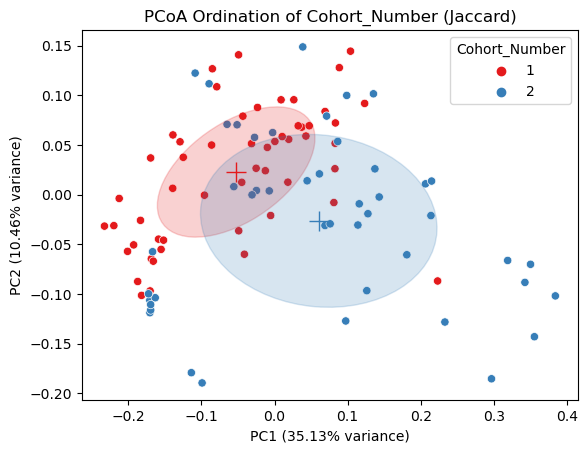

In [8]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    "Cohort_Number",
    output_file=vis_dir / "jaccard_pcoa_Cohort_Number.png",
)

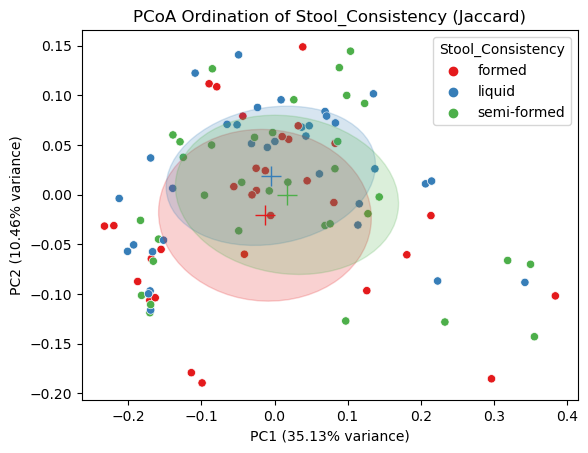

In [9]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    category="Stool_Consistency",
    output_file=vis_dir / "jaccard_pcoa_Stool_Consistency.png",
)

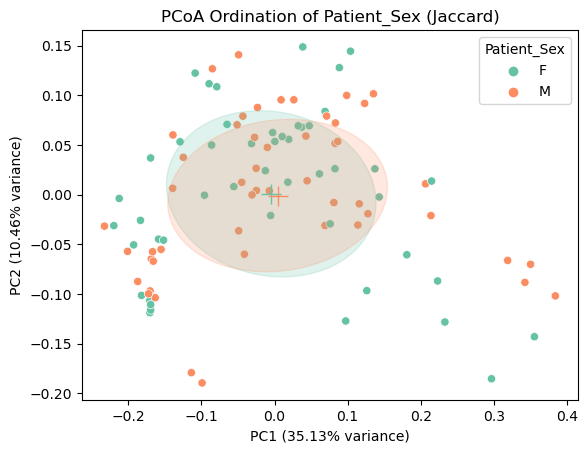

In [10]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    category="Patient_Sex",
    output_file=vis_dir / "jaccard_pcoa_Patient_Sex.png",
    palette="Set2"
)

#### Bray-Curtis Index

In [11]:
pcs_bc = q2.Artifact.load(core_metrics_res / "bray_curtis_pcoa_results.qza").view(OrdinationResults)

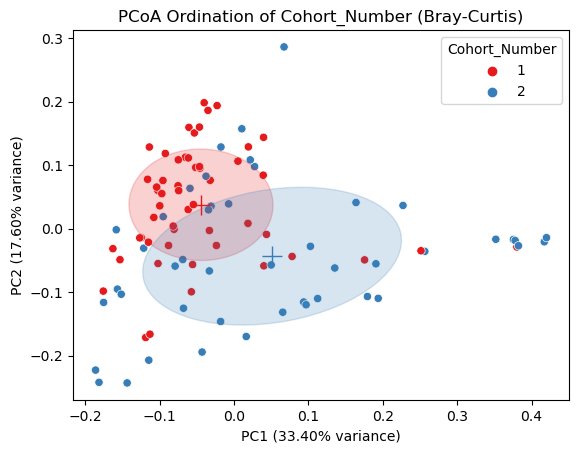

In [12]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Cohort_Number",
    output_file=vis_dir / "bray_curtis_pcoa_Cohort_Number.png",
)

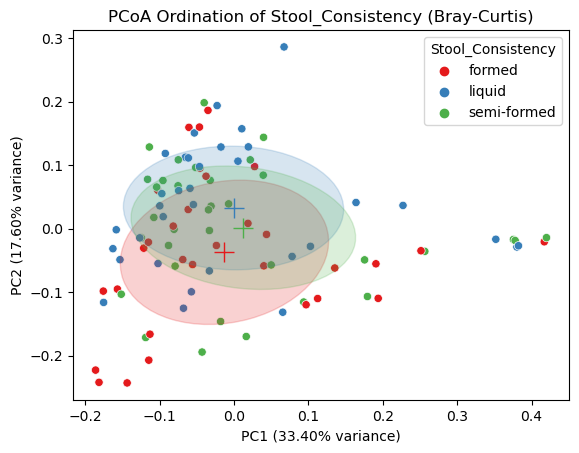

In [13]:
# plot stool consistency
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Stool_Consistency",
    output_file=vis_dir / "bray_curtis_pcoa_Stool_Consistency.png",
)

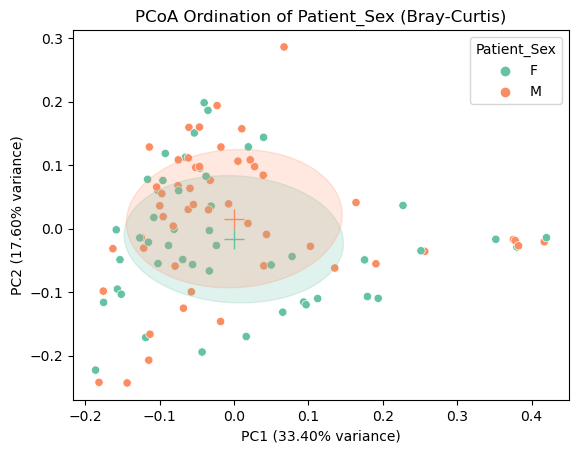

In [14]:
# plot patient sex
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Patient_Sex",
    output_file=vis_dir / "bray_curtis_pcoa_Patient_Sex.png",
    palette="Set2"
)

### Adonis test

#### Jaccard Index

In [15]:
! qiime diversity adonis \
    --i-distance-matrix $core_metrics_res/jaccard_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_fillna.tsv \
    --p-formula "Cohort_Number*Stool_Consistency*Patient_Sex*Sample_Day*Recovery_Day" \
    --o-visualization $output_dir/jaccard_adonis.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_adonis.qzv


In [16]:
! if [ -d $output_dir/jaccard_adonis ]; then rm -r $output_dir/jaccard_adonis; fi
! qiime tools export \
    --input-path $output_dir/jaccard_adonis.qzv \
    --output-path $output_dir/jaccard_adonis

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_adonis.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_adonis


In [17]:
adonis_j = pd.read_csv(output_dir / "jaccard_adonis" / "adonis.tsv", sep="\t").iloc[:-2]
adonis_j[adonis_j["Pr(>F)"] < 0.05]

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
Cohort_Number,1,0.410823,0.410823,7.497235,0.073634,0.001


In [18]:
adonis_j = utils.correct_for_multiple_testing(adonis_j, p_value_column="Pr(>F)")
adonis_j[adonis_j["reject_null"]]

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),q_value,reject_null
Cohort_Number,1,0.410823,0.410823,7.497235,0.073634,0.001,0.023,True


#### Bray-Curtis

In [19]:
! qiime diversity adonis \
    --i-distance-matrix $core_metrics_res/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_fillna.tsv \
    --p-formula "Cohort_Number*Stool_Consistency*Patient_Sex*Sample_Day*Recovery_Day" \
    --o-visualization $output_dir/bray_curtis_adonis.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_adonis.qzv


In [20]:
! qiime tools export \
    --input-path $output_dir/bray_curtis_adonis.qzv \
    --output-path $output_dir/bray_curtis_adonis

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_adonis.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_adonis


In [21]:
adonis_bc = pd.read_csv(output_dir / "bray_curtis_adonis" / "adonis.tsv", sep="\t").iloc[:-2]
adonis_bc[adonis_bc["Pr(>F)"] < 0.05]

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
Cohort_Number,1,0.436109,0.436109,7.771170,0.072488,0.001
Sample_Day,1,0.152865,0.152865,2.723956,0.025409,0.022
Cohort_Number:Stool_Consistency:Recovery_Day,2,0.259605,0.129803,2.312991,0.043150,0.011


In [22]:
adonis_bc = utils.correct_for_multiple_testing(adonis_bc, p_value_column="Pr(>F)")
adonis_bc[adonis_bc["reject_null"]]

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),q_value,reject_null
Cohort_Number,1,0.436109,0.436109,7.77117,0.072488,0.001,0.023,True


### Beta significance

This step is for generating visulization of the previously identified significant column in adonis test.

#### Jaccard Index

In [23]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $core_metrics_res/jaccard_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_categorical-cohort.tsv \
    --m-metadata-column cohort \
    --p-pairwise \
    --o-visualization $output_dir/jaccard_cohort_beta-group-significance.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_cohort_beta-group-significance.qzv


In [24]:
! qiime tools export \
    --input-path $output_dir/jaccard_cohort_beta-group-significance.qzv \
    --output-path $output_dir/jaccard_cohort_beta-group-significance


Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_cohort_beta-group-significance.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/jaccard_cohort_beta-group-significance


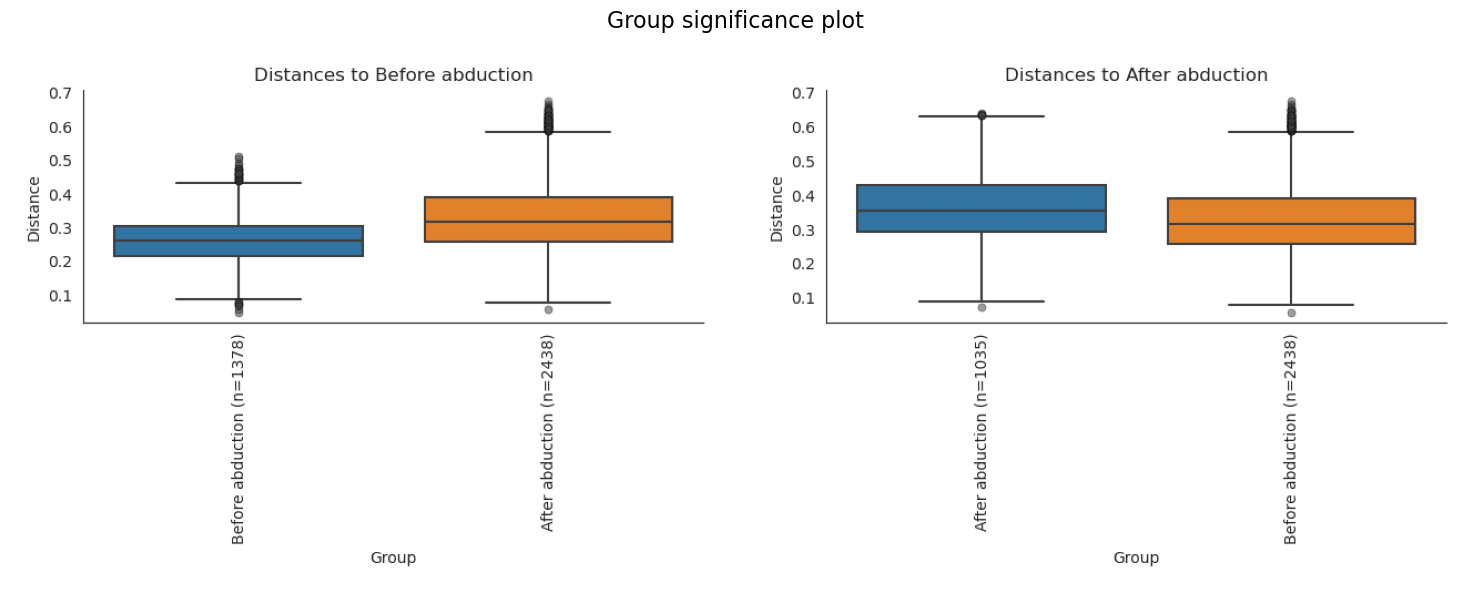

In [25]:
# Read both images
before_img = plt.imread(output_dir / "jaccard_cohort_beta-group-significance" /  "Before%20abduction-boxplots.png")
after_img = plt.imread(output_dir / "jaccard_cohort_beta-group-significance" /  "After%20abduction-boxplots.png")
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# set a common title
fig.suptitle('Group significance plot', fontsize=16)

# Display images
ax1.imshow(before_img)
ax1.axis('off')  # Hide axes

ax2.imshow(after_img)
ax2.axis('off')  # Hide axes

# Adjust layout and save
fig.tight_layout()
fig.savefig(vis_dir / "jaccard_cohort_beta-group-significance.png")

#### Bray-Curtis

In [26]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $core_metrics_res/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_categorical-cohort.tsv \
    --m-metadata-column cohort \
    --p-pairwise \
    --o-visualization $output_dir/bray_curtis_cohort_beta-group-significance.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_cohort_beta-group-significance.qzv


In [27]:
! qiime tools export \
    --input-path $output_dir/bray_curtis_cohort_beta-group-significance.qzv \
    --output-path $output_dir/bray_curtis_cohort_beta-group-significance

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_cohort_beta-group-significance.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/bray_curtis_cohort_beta-group-significance


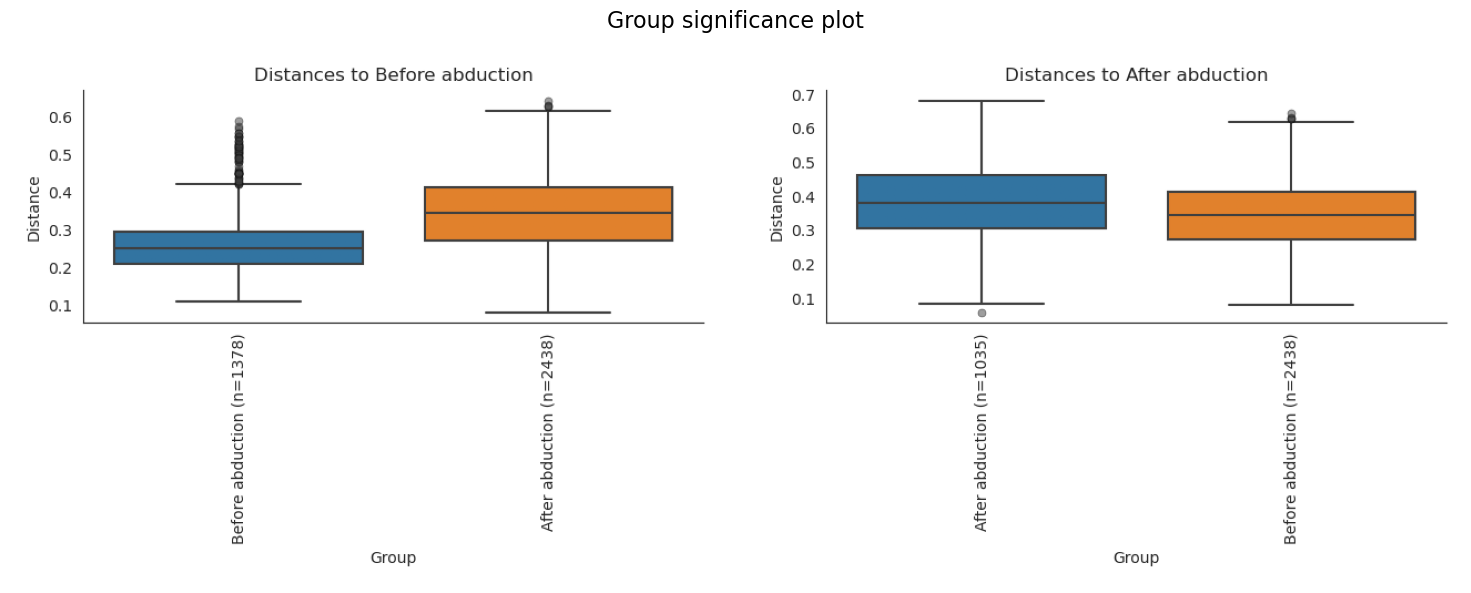

In [28]:
# Read both images
before_img = plt.imread(output_dir / "bray_curtis_cohort_beta-group-significance" /  "Before%20abduction-boxplots.png")
after_img = plt.imread(output_dir / "bray_curtis_cohort_beta-group-significance" /  "After%20abduction-boxplots.png")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# set a common title
fig.suptitle('Group significance plot', fontsize=16)

# Display images
ax1.imshow(before_img)
ax1.axis('off')  # Hide axes

ax2.imshow(after_img)
ax2.axis('off')  # Hide axes

# Adjust layout and save

fig.tight_layout()
fig.savefig(vis_dir / "bray_curtis_cohort_beta-group-significance.png")


### Beta correlation

In [29]:
! qiime diversity beta-correlation \
    --i-distance-matrix $core_metrics_res/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_fillna.tsv \
    --m-metadata-column Recovery_Day \
    --p-intersect-ids \
    --o-metadata-distance-matrix $output_dir/spearman-recov-day.qza \
    --o-mantel-scatter-visualization $output_dir/scatter-plot-recov-day.qzv

Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/spearman-recov-day.qza
Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/scatter-plot-recov-day.qzv


## Differential abundance

In [30]:
! qiime feature-table filter-features \
    --i-table $picrust_res/{metagenome}.qza \
    --p-min-frequency 25 \
    --p-min-samples 5 \
    --o-filtered-table $output_dir/{metagenome}_filtered.qza

Saved FeatureTable[Frequency] to: /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/pathway_abundance_filtered.qza


### Between cohort

In [ ]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $output_dir/{metagenome}_filtered.qza \
    --m-metadata-file $data_dir/metadata_categorical-cohort.tsv \
    --p-formula cohort \
    --p-reference-levels "cohort::Before abduction" \
    --o-differentials $output_dir/ancombc_differentials_cohort.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $output_dir/ancombc_differentials_cohort.qza \
    --o-visualization $output_dir/ancombc_da_barplot_cohort.qzv
# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $output_dir/ancombc_differentials_cohort.qza \
    --o-visualization $output_dir/ancombc_results_cohort.qzv

In [32]:
! if [ -d $output_dir/ancombc_differentials_cohort ]; then rm -r $output_dir/ancombc_differentials_cohort; fi
! qiime tools export \
    --input-path $output_dir/ancombc_differentials_cohort.qza \
    --output-path $output_dir/ancombc_differentials_cohort

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_cohort.qza as DataLoafPackageDirFmt to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_cohort


In [59]:
def retrive_significant_lfc(
    ancombc_res_dir: Path,
    meta: pd.DataFrame,
    category: str,
    ref_category: str,
    p_val_threshold: float = 0.05,
):
    """
    Retrieve significant log2foldchange and q-values from ANCOM-BC results

    Parameters
    ----------
    ancombc_res_dir : Path
        Directory containing ANCOM-BC results
    meta : pd.DataFrame
        Metadata table
    category : str
        Category of interest
    ref_category : str
        Reference category
    p_val_threshold : float, optional
        p-value threshold, by default 0.05

    Returns
    -------
    lfc_qval : pd.DataFrame
        DataFrame containing log2foldchange and q-values
    res : dict
        Dictionary containing significant results for each category
    """

    lfc = pd.read_csv(ancombc_res_dir / "lfc_slice.csv")
    qvals = pd.read_csv(ancombc_res_dir / "q_val_slice.csv")
    lfc_qval = pd.merge(
        lfc.drop("(Intercept)", axis=1), qvals.drop("(Intercept)", axis=1), on="id"
    )
    uniq_cat = [c for c in meta[category].unique() if c != ref_category]
    rename_dict = {"id": "metagene"}
    for cat in uniq_cat:
        rename_dict[f"{category}{cat}_x"] = f"log2foldchange_{cat}"
        rename_dict[f"{category}{cat}_y"] = f"q-value_{cat}"
    lfc_qval = lfc_qval.rename(columns=rename_dict)

    res = {}
    for cat in uniq_cat:
        res[cat] = lfc_qval[lfc_qval[f"q-value_{cat}"] < p_val_threshold]

    return lfc_qval, res

In [62]:
lfc_qval, res = retrive_significant_lfc(
    output_dir / "ancombc_differentials_cohort",
    pd.read_csv(data_dir / "metadata_categorical-cohort.tsv", sep="\t", index_col=0),
    "cohort",
    "Before abduction",
)

57

In [63]:
# save this dataframe as a csv file
lfc_qval.to_csv(output_dir / "ancombc_differentials_cohort" / "lfc_qval.csv", index=False)

In [107]:
lfc_qval_significant = res["After abduction"]
print(f"Number of significant pathways: {lfc_qval_significant.shape[0]}")

if lfc_qval_significant.shape[0] > 0:
    lfc_qval_significant.to_csv(vis_dir / "significant_pathways_by_cohort.csv", index=False)

Number of significant pathways: 57


### Between sex

In [ ]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $output_dir/{metagenome}_filtered.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Patient_Sex \
    --o-differentials $output_dir/ancombc_differentials_sex.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $output_dir/ancombc_differentials_sex.qza \
    --o-visualization $output_dir/ancombc_da_barplot_sex.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $output_dir/ancombc_differentials_sex.qza \
    --o-visualization $output_dir/ancombc_results_sex.qzv

In [38]:
! if [ -d $output_dir/ancombc_differentials_sex ]; then rm -r $output_dir/ancombc_differentials_sex; fi
! qiime tools export \
    --input-path $output_dir/ancombc_differentials_sex.qza \
    --output-path $output_dir/ancombc_differentials_sex

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_sex.qza as DataLoafPackageDirFmt to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_sex


In [65]:
lfc_qval_sex, res_sex = retrive_significant_lfc(
    output_dir / "ancombc_differentials_sex",
    meta,
    "Patient_Sex",
    "F",
)


In [66]:
lfc_qval_sex.to_csv(output_dir /  "ancombc_differentials_sex" / "lfc_qval.csv", index=False)

In [67]:
lfc_qval_significant = res_sex["M"]
print(f"Number of significant pathways: {lfc_qval_significant.shape[0]}")

Number of significant pathways: 0


### Between Stool_Consistency

In [ ]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $output_dir/{metagenome}_filtered.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --p-formula Stool_Consistency \
    --o-differentials $output_dir/ancombc_differentials_stool.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $output_dir/ancombc_differentials_stool.qza \
    --o-visualization $output_dir/ancombc_da_barplot_stool.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $output_dir/ancombc_differentials_stool.qza \
    --o-visualization $output_dir/ancombc_results_stool.qzv

In [68]:
name = "ancombc_differentials_stool"

In [44]:
! if [ -d $output_dir/$name ]; then rm -r $output_dir/$name; fi
! qiime tools export \
    --input-path $output_dir/{name}.qza \
    --output-path $output_dir/$name

Exported /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_stool.qza as DataLoafPackageDirFmt to directory /home/matchy233/study/alien/data/processed/pathway_abundance_downstream_analysis/ancombc_differentials_stool


In [69]:
lfc_qval_stool, res_stool = retrive_significant_lfc(
    output_dir / name,
    meta,
    "Stool_Consistency",
    "formed",
)

In [71]:
lfc_qval_stool.to_csv(output_dir / name / "lfc_qval.csv", index=False)

In [108]:
lfc_qval_significant_liquid = res_stool["liquid"]
lfc_qval_significant_semi_formed = res_stool["semi-formed"]

print(f"Number of significant pathways for liquid: {lfc_qval_significant_liquid.shape[0]}")
print(f"Number of significant pathways for semi-formed: {lfc_qval_significant_semi_formed.shape[0]}")

Number of significant pathways for liquid: 2
Number of significant pathways for semi-formed: 0


In [73]:
lfc_qval_significant_liquid

,metagene,log2foldchange_liquid,log2foldchange_semi-formed,q-value_liquid,q-value_semi-formed
134,PWY-5180,2.141376,0.631737,0.022271,1
136,PWY-5182,2.141376,0.631737,0.022271,1


In [109]:
# save lfc_qval_significant_liquid as a csv file
lfc_qval_significant_liquid.to_csv(vis_dir / "significant_pathways_by_stool_consistency_liquid.csv", index=False)

## Predictive Biomarker

In [48]:
feature_table = q2.Artifact.load(picrust_res / f"{metagenome}.qza").view(pd.DataFrame)


In [49]:

df = pd.merge(meta, feature_table, left_index=True, right_index=True)

In [50]:
all_cor_df = utils.calculate_spearman_correlation(
    df,
    exclude_columns=['sample-id', 'Cohort_Number', 'Recovery_Day', 'Patient_ID', 'Stool_Consistency', 'Patient_Sex', 'Sample_Day']
)

In [51]:
all_cor_df_filtered = all_cor_df.dropna(subset=["p_value"])
all_cor_df_filtered[all_cor_df_filtered["p_value"] < 0.05]

,correlated_column,correlation,p_value,sample_size


In [52]:
# if we find any significant correlations, we correct for multiple testing
all_cor_df_corrected = utils.correct_for_multiple_testing(
    all_cor_df_filtered.copy(),
    p_value_column="p_value"
)
all_cor_df_corrected[all_cor_df_corrected["reject_null"]]

,correlated_column,correlation,p_value,sample_size,q_value,reject_null
